# Imports

In [1]:
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
import timeit
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

# Load Data

In [2]:
# Load Training and Test data
train_dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root="dataset/", train=False, transform=transforms.ToTensor(), download=True)
#train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
#test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
print(type(train_dataset))
print(train_dataset)

<class 'torchvision.datasets.mnist.MNIST'>
Dataset MNIST
    Number of datapoints: 60000
    Root location: dataset/
    Split: Train
    StandardTransform
Transform: ToTensor()


In [4]:
for x,y in train_dataset:
  #print(x.shape,y, type(x))
  x = x[:,:,:14]
  #break

In [5]:
for x,y in train_dataset:
  print(x.shape,y, type(x))
  #x = x[:,:,:14]
  break

torch.Size([1, 28, 28]) 5 <class 'torch.Tensor'>


In [6]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: dataset/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

11493376/11490434 [==============================] - 0s 0us/step


In [8]:
x_train.shape

(60000, 28, 28)

# Construct left and right view of images

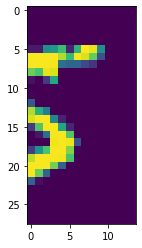

(60000, 28, 14)


In [9]:
left_imgs = np.zeros((60000,28,14))
right_imgs = np.zeros((60000,28,14))

for idx, img in enumerate(x_train):
    left_imgs[idx] = img[:,:14]
    right_imgs[idx] = img[:,14:]


plt.imshow(right_imgs[0])
plt.show()
print(left_imgs.shape)

## Making left and right view of images and appending as a tuple in data list

In [10]:
data = []

for idx, img in enumerate(x_train):
  left = img[:,:14]
  right = img[:,14:]
  data.append((left,right))

data = np.array(data)
print(data.shape)

(60000, 2, 28, 14)


# Converting left-right tuple list to torch.tensor

In [11]:
X = torch.tensor(data)
X.shape

torch.Size([60000, 2, 28, 14])

# Data loader for above tensor

In [12]:
train_loader = DataLoader(dataset=X, batch_size=64, shuffle=True)

In [13]:
for x in train_loader:
    print(x.shape)
    x = x.reshape(64,1,2,28,14)
    print(x.shape)
    break

torch.Size([64, 2, 28, 14])
torch.Size([64, 1, 2, 28, 14])


In [14]:
type(train_loader)

torch.utils.data.dataloader.DataLoader

# Autoencoder Model

### Feeding  batch of 64 imgs to left half feed and right half feed b4 the merged middle layer in the network

64 x 10 dimension output for both ;eft and right img batch as we have 64 imgs and embeddings are of size 10 as of now

In [15]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()        
        ### ENCODING
        self.convleft1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.poolleft1 = nn.MaxPool2d(2, 2)  # 8*14*7
        self.convleft2 = nn.Conv2d(8, 24, kernel_size=3, stride=1, padding=1)
        self.poolleft2 = nn.MaxPool2d(2, 2) # 24*7*3
        self.fcleft1 = nn.Linear(24*7*3, 64)
        self.fcleft2 = nn.Linear(64, 32)
        self.fcleft3 = nn.Linear(32, 10)
        
        self.convright1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.poolright1 = nn.MaxPool2d(2, 2)  # 8*14*7
        self.convright2 = nn.Conv2d(8, 24, kernel_size=3, stride=1, padding=1)
        self.poolright2 = nn.MaxPool2d(2, 2) # 24*7*3
        self.fcright1 = nn.Linear(24*7*3, 64)
        self.fcright2 = nn.Linear(64, 32)
        self.fcright3 = nn.Linear(32, 10)

        ### DECODING
        self.linearleft = nn.Linear(20, 392)
        self.linearright = nn.Linear(20, 392)
        
    def feed_left(self, x):
        plt.imshow(x[0,0,:,:])
        plt.show()

    def feed_right(self, x):
        plt.imshow(x[0,0,:,:])
        plt.show()
        
    def forward(self, x):
        #ENCODING
        left = x[:,:,0,:,:]
        right = x[:,:,1,:,:]

        # print(left.shape, right.shape)
        
        #  LEFT FIRST HALF
        x = F.relu(self.convleft1(left))
        x = self.poolleft1(x)
        x = F.relu(self.convleft2(x))
        x = self.poolleft2(x)
        x = x.reshape(64,-1) 
        hleft1 = F.relu(self.fcleft1(x))
        hleft2 = F.relu(self.fcleft2(hleft1))
        hleft3 = F.relu(self.fcleft3(hleft2))

        # RIGHT FIRST HALF
        y = F.relu(self.convright1(right))
        y = self.poolright1(y)
        y = F.relu(self.convright2(y))
        y = self.poolright2(y)
        y = y.reshape(64,-1) 
        hright1 = F.relu(self.fcright1(y))
        hright2 = F.relu(self.fcright2(hright1))
        hright3 = F.relu(self.fcright3(hright2))
        
        #MERGE
        hcommon = torch.cat((hleft3, hright3), 1)
        # print(hcommon.shape)
        
        #DECODING
        recleft = F.relu(self.linearleft(hcommon))
        recright = F.relu(self.linearright(hcommon))
        
        #Here output image is of dimension 392, need to reshape it to 28x14
        # print(recleft.shape, recright.shape )
        # recleft = recleft.reshape(64, 1, 1, 28, 14)
        # recright = recright.reshape(64, 1, 1, 28, 14)
        
        return(hcommon, recleft, recright, hleft1, hleft2, hright1, hright2)



# class NNet(nn.Module):
#     def __init__(self):
#         super().__init__()        
#         ### ENCODING
#         self.convleft1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
#         self.poolleft1 = nn.MaxPool2d(2, 2, return_indices=True)  # 8*14*7
#         self.convleft2 = nn.Conv2d(8, 24, kernel_size=3, stride=1, padding=1)
#         self.poolleft2 = nn.MaxPool2d(2, 2, return_indices=True) # 24*7*3
#         self.fcleft1 = nn.Linear(24*7*3, 64)
#         self.fcleft2 = nn.Linear(64, 32)
#         self.fcleft3 = nn.Linear(32, 10)
        
#         self.convright1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
#         self.poolright1 = nn.MaxPool2d(2, 2, return_indices=True)  # 8*14*7
#         self.convright2 = nn.Conv2d(8, 24, kernel_size=3, stride=1, padding=1)
#         self.poolright2 = nn.MaxPool2d(2, 2, return_indices=True) # 24*7*3
#         self.fcright1 = nn.Linear(24*7*3, 64)
#         self.fcright2 = nn.Linear(64, 32)
#         self.fcright3 = nn.Linear(32, 10)

#         ### DECODING
#         self.linearleft1 = nn.Linear(20, 64)
#         self.linearleft2 = nn.Linear(64, 24*7*3)
#         self.unpoolleft1 = nn.MaxUnpool2d(2, 2)
#         self.deconvleft1 = nn.ConvTranspose2d(24, 8, kernel_size=3, stride=1, padding=1)
#         self.unpoolleft2 = nn.MaxUnpool2d(2, 2)
#         self.deconvleft2 = nn.ConvTranspose2d(8, 1, kernel_size=3, stride=1, padding=1) 
#         # self.linearleft = nn.Linear(20, 392)

#         self.linearright1 = nn.Linear(20, 64)
#         self.linearright2 = nn.Linear(64, 24*7*3)
#         self.unpoolright1 = nn.MaxUnpool2d(2, 2)
#         self.deconvright1 = nn.ConvTranspose2d(24, 8, kernel_size=3, stride=1, padding=1)
#         self.unpoolright2 = nn.MaxUnpool2d(2, 2)
#         self.deconvright2 = nn.ConvTranspose2d(8, 1, kernel_size=3, stride=1, padding=1)
#         # self.linearright = nn.Linear(20, 392)
        
#     def feed_left(self, x):
#         plt.imshow(x[0,0,:,:])
#         plt.show()

#     def feed_right(self, x):
#         plt.imshow(x[0,0,:,:])
#         plt.show()
        
#     def forward(self, x):
#         #ENCODING
#         left = x[:,:,0,:,:]
#         right = x[:,:,1,:,:]
        
#         #  LEFT FIRST HALF
#         x = F.relu(self.convleft1(left))
#         x, left_indices1 = self.poolleft1(x)
#         x = F.relu(self.convleft2(x))
#         x, left_indices2 = self.poolleft2(x)
#         x = x.reshape(64,-1) 
#         hleft1 = F.relu(self.fcleft1(x))
#         hleft2 = F.relu(self.fcleft2(hleft1))
#         hleft3 = F.relu(self.fcleft3(hleft2))

#         # RIGHT FIRST HALF
#         y = F.relu(self.convright1(right))
#         y, right_indices1 = self.poolright1(y)
#         y = F.relu(self.convright2(y))
#         y, right_indices2 = self.poolright2(y)
#         y = y.reshape(64,-1) 
#         hright1 = F.relu(self.fcright1(y))
#         hright2 = F.relu(self.fcright2(hright1))
#         hright3 = F.relu(self.fcright3(hright2))
        
#         #MERGE
#         hcommon = torch.cat((hleft3, hright3), 1)
#         #print("hcommon ",hcommon.shape)
#         #DECODING
#         # recleft = F.relu(self.linearleft(hcommon))
#         a = F.relu(self.linearleft1(hcommon))
#         a = F.relu(self.linearleft2(a))
#         a = self.unpoolleft1(a, left_indices2)
#         a = F.relu(self.deconvleft1(a))
#         a = self.unpoolleft2(a, left_indices1)
#         recleft = F.relu(self.deconvleft2(a))

#         # recright = F.relu(self.linearright(hcommon))
#         a = F.relu(self.linearright1(hcommon))
#         a = F.relu(self.linearright2(a))
#         a = self.unpoolright1(a, right_indices2)H
#         a = F.relu(self.deconvright1(a))
#         a = self.unpoolright2(a, right_indices1)
#         recright = F.relu(self.deconvright2(a))

#         #Here output image is of dimension 392, need to reshape it to 28x14
#         #print(recleft.shape, recright.shape )
#         recleft = recleft.reshape(64, 1, 1, 28, 14)
#         recright = recright.reshape(64, 1, 1, 28, 14)
        
#         return(hcommon, recleft, recright, hleft1, hleft2, hright1, hright2)

In [16]:
def correlation(h_layers):
    lambda_arr = [0.02, 0.001, 0.05]
    corr_arr = np.zeros(len(lambda_arr))
    for index,pair in enumerate(h_layers):
        lmbda = lambda_arr[index]
        x=pair[0]
        y=pair[1]
        
        x_mean = torch.mean(x, axis=0)
        y_mean = torch.mean(y, axis=0)
        x_numerator1 = x-x_mean
        y_numerator1 = y-y_mean
        
        corr_numerator = torch.sum(x_numerator1*y_numerator1, axis=0)
        corr_denominator1 = torch.sqrt(torch.sum(x_numerator1*x_numerator1, axis=0) + 1e-8)
        corr_denominator2 = torch.sqrt(torch.sum(y_numerator1*y_numerator1, axis=0) + 1e-8)
        corr = corr_numerator / (corr_denominator1 * corr_denominator2)
        
        corr_arr[index] = lmbda*torch.sum(corr)
    return np.sum(corr_arr)

In [ ]:
# model = NN()
# criterion = nn.MSELoss()
# optimizer = nn.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# num_epochs=5

In [ ]:
# for i in num_epochs:
#     for x in train_loader:
#         x = x.reshape(64,1,2,28,14)
#         x = x.float()

#         left = x[:, :, 0, :, :]
#         right = x[:, :,1, :, :]

#         templ, tempr = x.detach().clone(), x.detach().clone()
#         templ[:, :, 0, :, :]=0
#         tempr[:, :, 1, :, :]=0

#         h0, left0, right0, hleft_1, hleft_2, hright_1, hright_2 = model(x) #Giving both left and right as input
#         h1, left1, right1, _, _, _, _ = model(tempr) #Giving only left as input
#         h2, left2, right2, _, _, _, _ = model(templ) #Giving only right as input

#         #MSE Loss + Correlation
#         loss=criterion(right1, left)+criterion(left2, right)+criterion(left1, left)+criterion(right2, right)-correlation([[h1, h2], [hleft_1, hright_1], [hleft_2, hright_2]])

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [18]:
def reset_network_params(model):
  for layer in model.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

In [19]:
def plot_loss(train_loss, num_epoch):
  plt.plot(train_loss, '-ro')
  plt.xlabel("Epoch")
  plt.ylabel("Train loss")
  plt.title("Train Loss vs Epoch")

In [44]:
model = NN()
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [45]:
reset_network_params(model)
num_epochs=50
train_loss = []
for i in tqdm(range(num_epochs)):
    j = 0
    epoch_loss = 0.0
    for x in train_loader:
        if (x.shape[0]!=64):
            continue
        x = x.to(device=device)
        x = x.reshape(64,1,2,28,14)
        x = x.float()

        left = x[:, :, 0, :, :].to(device=device)
        right = x[:, :,1, :, :].to(device=device)
        # print(left.shape, right.shape)
        left = left.reshape(64,1,1,28,14)
        right = right.reshape(64,1,1,28,14)
        #break
        templ, tempr = x.detach().clone(), x.detach().clone()
        templ[:, :, 0, :, :]=0
        tempr[:, :, 1, :, :]=0
        #print(x.shape)
        h0, left0, right0, hleft_1, hleft_2, hright_1, hright_2 = model(x) #Giving both left and right as input
        left0 = left0.reshape(64,1,1,28,14)
        right0 = right0.reshape(64,1,1,28,14)
        h1, left1, right1, _, _, _, _ = model(tempr) #Giving only left as input
        h2, left2, right2, _, _, _, _ = model(templ) #Giving only right as input
        left1 = left1.reshape(64,1,1,28,14)
        right2 = right2.reshape(64,1,1,28,14)
        left2 = left2.reshape(64,1,1,28,14)
        right1 = right1.reshape(64,1,1,28,14)
        #print()
        #MSE Loss + Correlation
        loss=criterion(left0, left)+criterion(right0, right)+criterion(left2, left)+criterion(right1, right)-correlation([[h1, h2], [hleft_1, hright_1], [hleft_2, hright_2]])
        epoch_loss += loss
        #print(h0.shape, left0.shape, right0.shape, hleft_1.shape, hleft_2.shape, hright_1.shape, hright_2.shape)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #break
    train_loss.append(epoch_loss)
    #break
    # print("epoch :",i,"   Loss :",epoch_loss)

100%|██████████| 50/50 [07:54<00:00,  9.48s/it]


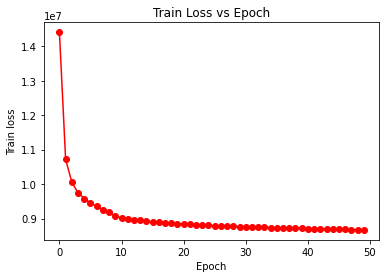

In [46]:
plot_loss(train_loss, num_epochs)

In [52]:
for x in train_loader:
    x = x.to(device=device)
    x = x.reshape(64,1,2,28,14)
    x = x.float()
    templ, tempr = x.detach().clone(), x.detach().clone()
    templ[:, :, 0, :, :]=0
    tempr[:, :, 1, :, :]=0
    # h0, left0, right0, hleft_1, hleft_2, hright_1, hright_2 = model(x) #Giving both left and right as input
    h1, left1, right1, _, _, _, _ = model(tempr) #Giving only left as input
    h2, left2, right2, _, _, _, _ = model(templ) #Giving only right as input
    left1 = left1.reshape(64,1,1,28,14)
    right2 = right2.reshape(64,1,1,28,14)
    left2 = left2.reshape(64,1,1,28,14)
    right1 = right1.reshape(64,1,1,28,14)
    break

print(h0.shape, left0.shape, right0.shape, hleft_1.shape, hleft_2.shape, hright_1.shape, hright_2.shape)

torch.Size([64, 20]) torch.Size([64, 1, 1, 28, 14]) torch.Size([64, 1, 1, 28, 14]) torch.Size([64, 64]) torch.Size([64, 32]) torch.Size([64, 64]) torch.Size([64, 32])


In [48]:
x.shape

torch.Size([64, 1, 2, 28, 14])

In [49]:
def show_sample_reconstructions(reconstrucions, actual):
  reconstrucions = reconstrucions.reshape(64,1,1,28,14)
  w=10
  h=10
  fig=plt.figure(figsize=(24, 12))
  columns = 16
  rows = 8
  idx = 0
  act_idx = np.arange(2, 64 , 2) 
  recons_idx = np.arange(1, 64 , 2)
  for i in range(0, columns*rows-1 ):
      
      fig.add_subplot(rows, columns, recons_idx[i]) 
    #   print(reconstrucions.shape)
      plt.imshow(reconstrucions[idx,0,0,:,:])
      fig.add_subplot(rows, columns, act_idx[i]) 
      plt.imshow(actual[idx,0,0,:,:])
      #fig.add_subplot(rows, columns, i+1) 
      #plt.imshow(reconstrucions[idx,0,0,:,:])
      #fig.add_subplot(rows, columns, i+2) 
      #plt.imshow(actual[idx,0,0,:,:])  
      idx += 1
  plt.show()

(64, 1, 2, 28, 14)


IndexError: ignored

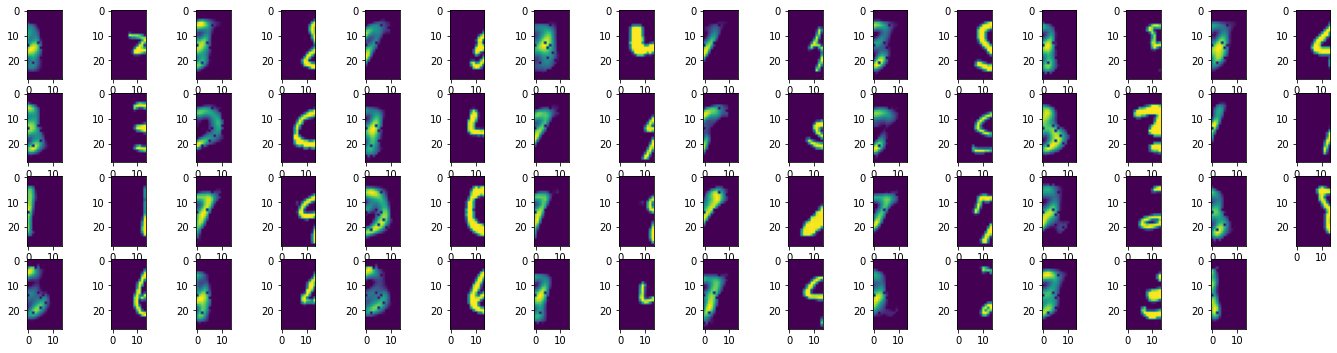

In [53]:
actual = x.cpu().detach().numpy()
print(actual.shape)
actual = actual[:,:,0,:,:].reshape(64,1,1,28,14)
show_sample_reconstructions(right1.cpu().detach().numpy(), actual)

IndexError: ignored

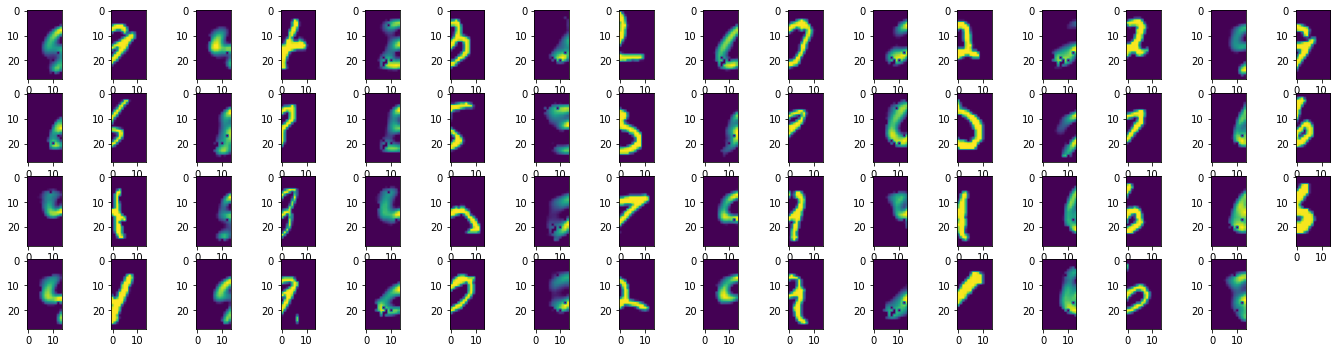

In [51]:
actual = x.cpu().detach().numpy()
actual = actual[:,:,1,:,:].reshape(64,1,1,28,14)
show_sample_reconstructions(left2.cpu().detach().numpy(), actual)

In [ ]:
np.arange(1,64,2)

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63])